<span style="font-size: 5em">🦜</span>

# __LangGraph Essentials__
## Lab 2: Parallel Execution
<div style="display:flex; align-items:flex-start;">
  <img src="./assets/Parallel.png" width="300" style="margin-right:15px;"/>
</div>

LangGraph enables parallel execution when a node has multiple outgoing edges. This notebook demonstrates how to build graphs with branching paths that execute simultaneously and then converge. We will use the operator.add reducer to accumulate results from parallel branches.


In [2]:
from IPython.display import Image, display
import operator
from typing import Annotated, List, Literal, TypedDict
from langgraph.graph import END, START, StateGraph
from langgraph.types import Command, interrupt

<a id='state_with_reducer'></a>


In [3]:
class State(TypedDict):
    nlist: Annotated[List[str], operator.add]

<a id='parallel_nodes'></a>


In [4]:
def node_a(state: State) -> State:
    print(f"Adding 'A' to {state['nlist']}")
    return(State(nlist = ["A"]))

def node_b(state: State) -> State:
    print(f"Adding 'B' to {state['nlist']}")
    return(State(nlist = ["B"]))

def node_c(state: State) -> State:
    print(f"Adding 'C' to {state['nlist']}")
    return(State(nlist = ["C"]))

def node_bb(state: State) -> State:
    print(f"Adding 'BB' to {state['nlist']}")
    return(State(nlist = ["BB"]))

def node_cc(state: State) -> State:
    print(f"Adding 'CC' to {state['nlist']}")
    return(State(nlist = ["CC"]))

def node_d(state: State) -> State:
    print(f"Adding 'D' to {state['nlist']}")
    return(State(nlist = ["D"]))

<a id='parallel_graph'></a>


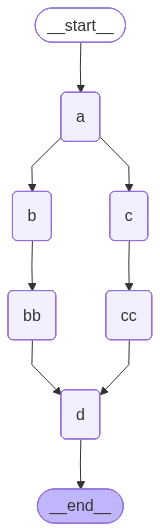

In [5]:
builder = StateGraph(State)

# Add nodes
builder.add_node("a", node_a)
builder.add_node("c", node_c)
builder.add_node("b", node_b)
builder.add_node("bb", node_bb)
builder.add_node("cc", node_cc)
builder.add_node("d", node_d)

# Add edges
builder.add_edge(START,"a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "bb")
builder.add_edge("c", "cc")
builder.add_edge("bb", "d")
builder.add_edge("cc", "d")
builder.add_edge("d",END)

# Compile and display
graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

<a id='parallel_execution'></a>


In [6]:
initial_state = State(
    nlist = ["Initial String:"]
)
graph.invoke(initial_state)

Adding 'A' to ['Initial String:']
Adding 'B' to ['Initial String:', 'A']
Adding 'C' to ['Initial String:', 'A']
Adding 'CC' to ['Initial String:', 'A', 'B', 'C']
Adding 'BB' to ['Initial String:', 'A', 'B', 'C']
Adding 'D' to ['Initial String:', 'A', 'B', 'C', 'BB', 'CC']


{'nlist': ['Initial String:', 'A', 'B', 'C', 'BB', 'CC', 'D']}

## Takeaways

Setup:

- State: You added a [reducer function](#state_with_reducer) in the state definition using Annotated with operator.add
- Graph: You used [add_edge()](#parallel_graph) to create parallel paths from node 'a' to both 'b' and 'c'

Execution:

- Runtime: [Nodes b and c](#parallel_nodes) operate in parallel, executing simultaneously
- The reducer function merges the values returned from parallel branches
- Results from node b and c are stored to state before starting node bb and cc

Result:

- The [final result](#parallel_execution) contains all values added to `nlist` by all nodes
- Values accumulate in the order nodes complete execution

Try Next:

- Try adding a 3rd parallel path from node 'a'
- Rather than joining at d, have bb and cc pass control to END. Are values still merged?
- Change the reducer from operator.add to a different function to see how state merging changes

# My own test

## Example 1

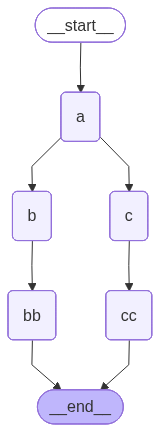

In [7]:
builder = StateGraph(State)

# Add nodes
builder.add_node("a", node_a)
builder.add_node("b", node_b)
builder.add_node("c", node_c)
builder.add_node("bb", node_bb)
builder.add_node("cc", node_cc)
# builder.add_node("d", node_d)

# Add edges
builder.add_edge(START,"a")
builder.add_edge("b", "bb")
builder.add_edge("a", "c")
builder.add_edge("a", "b")
builder.add_edge("c", "cc")
builder.add_edge("bb",END)
builder.add_edge("cc", END)

# Compile and display
graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [8]:
initial_state = State(
    nlist = ["Initial String:"]
)
graph.invoke(initial_state)

Adding 'A' to ['Initial String:']
Adding 'B' to ['Initial String:', 'A']
Adding 'C' to ['Initial String:', 'A']
Adding 'CC' to ['Initial String:', 'A', 'B', 'C']
Adding 'BB' to ['Initial String:', 'A', 'B', 'C']


{'nlist': ['Initial String:', 'A', 'B', 'C', 'BB', 'CC']}

## Example 2

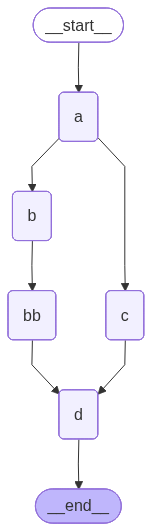

In [9]:
builder = StateGraph(State)

# Add nodes
builder.add_node("a", node_a)
builder.add_node("b", node_b)
builder.add_node("c", node_c)
builder.add_node("bb", node_bb)
# builder.add_node("cc", node_cc)
builder.add_node("d", node_d)

# Add edges
builder.add_edge(START,"a")
builder.add_edge("b", "bb")
builder.add_edge("a", "c")
builder.add_edge("a", "b")
builder.add_edge("c", "d")
builder.add_edge("bb","d")
builder.add_edge("d", END)

# Compile and display
graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [10]:
print(graph.get_graph().draw_mermaid())

---
config:
  flowchart:
    curve: linear
---
graph TD;
	__start__([<p>__start__</p>]):::first
	a(a)
	b(b)
	c(c)
	bb(bb)
	d(d)
	__end__([<p>__end__</p>]):::last
	__start__ --> a;
	a --> b;
	a --> c;
	b --> bb;
	bb --> d;
	c --> d;
	d --> __end__;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc



In [36]:
initial_state = State(
    nlist = ["Initial String:"]
)
graph.invoke(initial_state)

Adding 'A' to ['Initial String:']
Adding 'B' to ['Initial String:', 'A']
Adding 'C' to ['Initial String:', 'A']
Adding 'BB' to ['Initial String:', 'A', 'B', 'C']
Adding 'D' to ['Initial String:', 'A', 'B', 'C']
Adding 'D' to ['Initial String:', 'A', 'B', 'C', 'BB', 'D']


{'nlist': ['Initial String:', 'A', 'B', 'C', 'BB', 'D', 'D']}

## Example 3

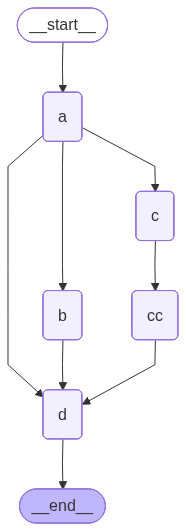

In [39]:
builder = StateGraph(State)

# Add nodes
builder.add_node("a", node_a)
builder.add_node("b", node_b)
builder.add_node("c", node_c)
# builder.add_node("bb", node_bb)
builder.add_node("cc", node_cc)
builder.add_node("d", node_d)

# Add edges
builder.add_edge(START,"a")
builder.add_edge("a", "c")
builder.add_edge("a", "b")
builder.add_edge("c", "cc")
builder.add_edge("a","d")
builder.add_edge("b","d")
builder.add_edge("cc","d")
builder.add_edge("d", END)

# Compile and display
graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [40]:
initial_state = State(
    nlist = ["Initial String:"]
)
graph.invoke(initial_state)

Adding 'A' to ['Initial String:']
Adding 'B' to ['Initial String:', 'A']
Adding 'C' to ['Initial String:', 'A']
Adding 'D' to ['Initial String:', 'A']
Adding 'CC' to ['Initial String:', 'A', 'B', 'C', 'D']
Adding 'D' to ['Initial String:', 'A', 'B', 'C', 'D']
Adding 'D' to ['Initial String:', 'A', 'B', 'C', 'D', 'CC', 'D']


{'nlist': ['Initial String:', 'A', 'B', 'C', 'D', 'CC', 'D', 'D']}

In [42]:
print(graph.get_graph().draw_mermaid())

---
config:
  flowchart:
    curve: linear
---
graph TD;
	__start__([<p>__start__</p>]):::first
	a(a)
	b(b)
	c(c)
	cc(cc)
	d(d)
	__end__([<p>__end__</p>]):::last
	__start__ --> a;
	a --> b;
	a --> c;
	a --> d;
	b --> d;
	c --> cc;
	cc --> d;
	d --> __end__;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc



## Example 4

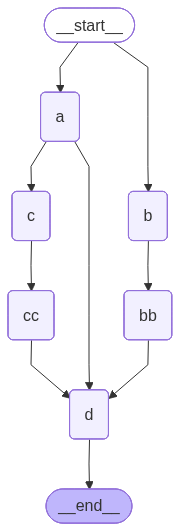

In [15]:
builder = StateGraph(State)

# Add nodes
builder.add_node("a", node_a)
builder.add_node("b", node_b)
builder.add_node("c", node_c)
builder.add_node("bb", node_bb)
builder.add_node("cc", node_cc)
builder.add_node("d", node_d)

# Add edges
builder.add_edge(START,"a")
builder.add_edge(START, "b")
builder.add_edge("a", "c")
builder.add_edge("c", "cc")
builder.add_edge("b", "bb")
builder.add_edge("a","d")
builder.add_edge("bb","d")
builder.add_edge("cc","d")
builder.add_edge("d", END)

# Compile and display
graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [16]:
initial_state = State(
    nlist = ["Initial String:"]
)
graph.invoke(initial_state)

Adding 'A' to ['Initial String:']
Adding 'B' to ['Initial String:']
Adding 'C' to ['Initial String:', 'A', 'B']
Adding 'D' to ['Initial String:', 'A', 'B']
Adding 'BB' to ['Initial String:', 'A', 'B']
Adding 'CC' to ['Initial String:', 'A', 'B', 'BB', 'C', 'D']
Adding 'D' to ['Initial String:', 'A', 'B', 'BB', 'C', 'D']
Adding 'D' to ['Initial String:', 'A', 'B', 'BB', 'C', 'D', 'CC', 'D']


{'nlist': ['Initial String:', 'A', 'B', 'BB', 'C', 'D', 'CC', 'D', 'D']}

In [17]:
print(graph.get_graph().draw_mermaid())

---
config:
  flowchart:
    curve: linear
---
graph TD;
	__start__([<p>__start__</p>]):::first
	a(a)
	b(b)
	c(c)
	bb(bb)
	cc(cc)
	d(d)
	__end__([<p>__end__</p>]):::last
	__start__ --> a;
	__start__ --> b;
	a --> c;
	a --> d;
	b --> bb;
	bb --> d;
	c --> cc;
	cc --> d;
	d --> __end__;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc



In [18]:
inputs = {"nlist": ["Initial String:"]}

print(f"{'Step':<10} | {'Node':<10} | {'Update (Output)'}")
print("-" * 50)

step_counter = 0

# O segredo é usar stream_mode="updates"
for event in graph.stream(inputs, stream_mode="updates"):
    # Cada 'event' é um dicionário onde a chave é o nome do nó que acabou de rodar
    for node_name, update_value in event.items():
        # Se mais de um nó aparecer aqui no mesmo evento, pode indicar paralelismo
        # ou você pode incrementar o contador por evento recebido
        step_counter += 1
        print(f"{step_counter:<10} | {node_name:<10} | {update_value}")

Step       | Node       | Update (Output)
--------------------------------------------------
Adding 'A' to ['Initial String:']
1          | a          | {'nlist': ['A']}
Adding 'B' to ['Initial String:']
2          | b          | {'nlist': ['B']}
Adding 'C' to ['Initial String:', 'A', 'B']
3          | c          | {'nlist': ['C']}
Adding 'BB' to ['Initial String:', 'A', 'B']
4          | bb         | {'nlist': ['BB']}
Adding 'D' to ['Initial String:', 'A', 'B']
5          | d          | {'nlist': ['D']}
Adding 'D' to ['Initial String:', 'A', 'B', 'BB', 'C', 'D']
Adding 'CC' to ['Initial String:', 'A', 'B', 'BB', 'C', 'D']
6          | d          | {'nlist': ['D']}
7          | cc         | {'nlist': ['CC']}
Adding 'D' to ['Initial String:', 'A', 'B', 'BB', 'C', 'D', 'CC', 'D']
8          | d          | {'nlist': ['D']}
